In [1]:
cd ../testing

/media/wintermute/work/valjax/testing


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('../config/clean.mplstyle')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import jax
import valfunc as vf

In [18]:
# algo params
alg0 = {
    'N': 1000, # grid size
    'flo': 0.2, # rel k grid min
    'fhi': 1.5, # rel k grid max
    'ε': 1e-4, # utility cutoff
}

In [19]:
# simple parameters
par0 = {
    'β': 0.95, # discount rate
    'δ': 0.1, # depreciation rate
    'α': 0.35, # capital exponent
    'z': 1.0, # productivity
}

In [24]:
mod = vf.Capital(par0, **alg0)

In [25]:
v1, kp1, ret, hist = mod.j_value_solve(K=400)

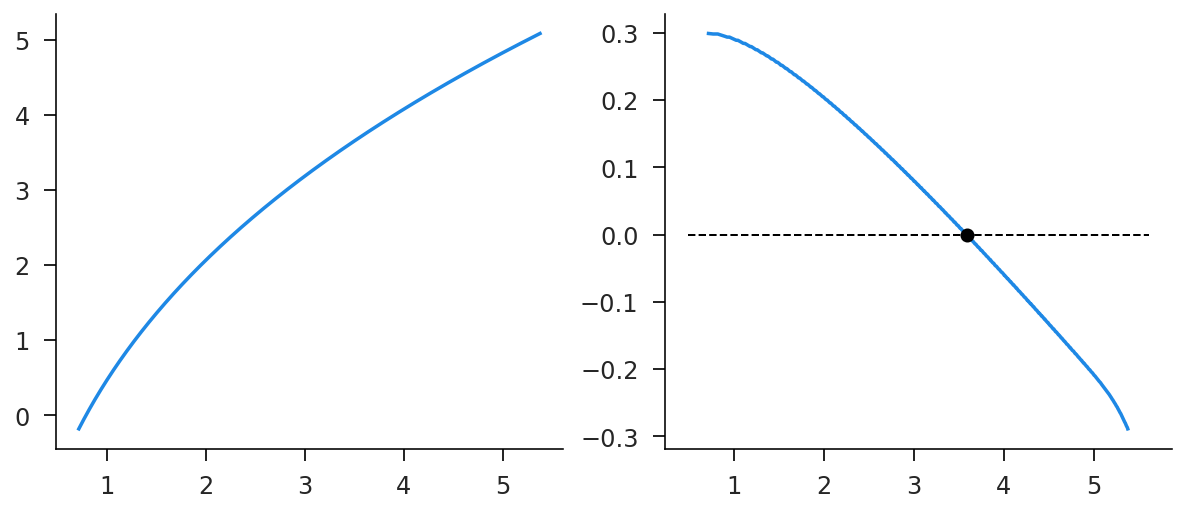

In [26]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 4))
ax0.plot(mod.k_grid, v1)
ax1.plot(mod.k_grid, kp1-mod.k_grid)
ax1.hlines(0, *ax1.get_xlim(), linestyle='--', linewidth=1, color='k');
ax1.scatter(mod.kss, 0, c='k', zorder=10);

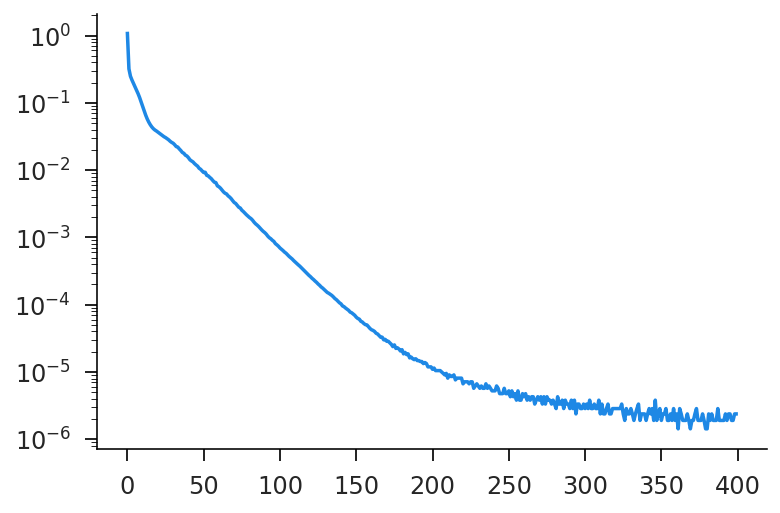

In [27]:
pd.Series(hist['err']).plot(logy=True);